In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import cv2
import pickle
import pandas as pd
import re
from astropy.nddata import Cutout2D
import cv2

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
model_64px = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/64pxmodel')
model_64px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0     

In [3]:
model_32px = tf.keras.models.load_model('D:/Workshop/PhD/Models/CNN for fbm Fields/32pxmodel')
model_32px.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 256)       2560      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 256)         0     

In [4]:
progress_df = pd.read_csv('D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px/progress.csv')
progress_df=progress_df.drop(columns = ['H','S'])
progress_df

,Direction,coords
0,l000,"[359.97972099949186, 0.040683222371426846]"
1,l002,"[2.1806678248157163, 0.04199591122993718]"
2,l004,"[4.422267619137547, -0.03956923833120953]"
3,l006,"[6.621406735872328, -0.04000965792996351]"
4,l008,"[8.82163708762842, -0.0396701575320798]"
...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]"
159,l352,"[352.02568077150545, -0.03962198378747212]"
160,l354,"[354.2244123311806, -0.03977051553483858]"
161,l356,"[356.3859330004788, 0.031006999951276433]"


In [5]:
l_list = []
b_list = []

for _, x in progress_df.iterrows():
    text = x['coords']
    pattern = r'\[.*,'
    m=re.search(pattern,text)[0]
    l_list.append(float(m[1:-1]))
    pattern = r',.*\]'
    m=re.search(pattern,text)[0]
    b_list.append(float(m[1:-1]))

progress_df['l']=l_list
progress_df['b']=b_list
progress_df

,Direction,coords,l,b
0,l000,"[359.97972099949186, 0.040683222371426846]",359.979721,0.040683
1,l002,"[2.1806678248157163, 0.04199591122993718]",2.180668,0.041996
2,l004,"[4.422267619137547, -0.03956923833120953]",4.422268,-0.039569
3,l006,"[6.621406735872328, -0.04000965792996351]",6.621407,-0.040010
4,l008,"[8.82163708762842, -0.0396701575320798]",8.821637,-0.039670
...,...,...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]",349.826149,-0.035415
159,l352,"[352.02568077150545, -0.03962198378747212]",352.025681,-0.039622
160,l354,"[354.2244123311806, -0.03977051553483858]",354.224412,-0.039771
161,l356,"[356.3859330004788, 0.031006999951276433]",356.385933,0.031007


In [6]:
progress_df['l_shift'] = (progress_df['l'] + 180) % 360 - 180
progress_df

,Direction,coords,l,b,l_shift
0,l000,"[359.97972099949186, 0.040683222371426846]",359.979721,0.040683,-0.020279
1,l002,"[2.1806678248157163, 0.04199591122993718]",2.180668,0.041996,2.180668
2,l004,"[4.422267619137547, -0.03956923833120953]",4.422268,-0.039569,4.422268
3,l006,"[6.621406735872328, -0.04000965792996351]",6.621407,-0.040010,6.621407
4,l008,"[8.82163708762842, -0.0396701575320798]",8.821637,-0.039670,8.821637
...,...,...,...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]",349.826149,-0.035415,-10.173851
159,l352,"[352.02568077150545, -0.03962198378747212]",352.025681,-0.039622,-7.974319
160,l354,"[354.2244123311806, -0.03977051553483858]",354.224412,-0.039771,-5.775588
161,l356,"[356.3859330004788, 0.031006999951276433]",356.385933,0.031007,-3.614067


In [7]:
def whole_tile(img, model, input_size, size = 1000):
    img_size_px = np.shape(img)
    position_x = int(img_size_px[0]//2)
    position_y = int(img_size_px[0]//2)
    position = (position_x,position_y)
    size = (size,size)
    cutout = Cutout2D(img,position=position,size=size)
    img = np.asarray(cutout.data)
    
    img = img/np.nanmax(img) * 255
    img = np.uint8(img)

    mask = np.uint8(np.isnan(img))
    array_conv=cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
    
    m_1_field = np.mean(array_conv)
    s_1_field = np.std(array_conv)
    m_2_field = 0
    s_2_field = 1/4
    
    x = array_conv * s_2_field/s_1_field
    x += (m_2_field-m_1_field*s_2_field/s_1_field)
    x[np.where(x>1.)] = 1.
    x[np.where(x<-1.)] = -1.
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    
    x = cv2.resize(x, (input_size,input_size))    
    x = x.reshape(1, input_size, input_size, 1)

    return model.predict(x)[0]

In [8]:
PATH = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_fulltile/DataCubes'

H_mean = []
S_mean = []
H_64_list = []
S_64_list = []
H_32_list = []
S_32_list = []
for filename in tqdm(os.listdir(PATH)):
    filepath = f'{PATH}/{filename}'
    cube = pickle.load( open(filepath, "rb" ) )
    column_density = cube[0]
    H_64,S_64 = whole_tile(column_density, model_64px, 64)
    H_32,S_32 = whole_tile(column_density, model_32px, 32)
    H_64_list.append(H_64)
    S_64_list.append(S_64)
    H_32_list.append(H_32)
    S_32_list.append(S_32)
    H_mean.append(np.nanmean(cube[1].flatten()))
    S_mean.append(np.nanmean(cube[2].flatten()))
    
progress_df['H_mean_64'] = H_mean
progress_df['S_mean_64'] = S_mean
progress_df['H_whole_64'] = H_64_list
progress_df['S_whole_64'] = S_64_list
progress_df['H_whole_32'] = H_32_list
progress_df['S_whole_32'] = S_32_list
progress_df

100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [04:19<00:00,  1.59s/it]


,Direction,coords,l,b,l_shift,H_mean_64,S_mean_64,H_whole_64,S_whole_64,H_whole_32,S_whole_32
0,l000,"[359.97972099949186, 0.040683222371426846]",359.979721,0.040683,-0.020279,0.860149,1.443457,0.048682,1.965678,0.138637,2.270564
1,l002,"[2.1806678248157163, 0.04199591122993718]",2.180668,0.041996,2.180668,0.849820,1.059476,0.339473,0.650423,0.442768,0.911158
2,l004,"[4.422267619137547, -0.03956923833120953]",4.422268,-0.039569,4.422268,0.904857,0.970627,0.296248,0.376416,0.322419,0.670171
3,l006,"[6.621406735872328, -0.04000965792996351]",6.621407,-0.040010,6.621407,0.816800,0.937207,0.239530,0.173420,0.320261,0.463360
4,l008,"[8.82163708762842, -0.0396701575320798]",8.821637,-0.039670,8.821637,0.878033,0.908528,0.208847,0.183470,0.299333,0.651468
...,...,...,...,...,...,...,...,...,...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]",349.826149,-0.035415,-10.173851,0.837585,0.959422,0.275164,0.409872,0.322469,0.617389
159,l352,"[352.02568077150545, -0.03962198378747212]",352.025681,-0.039622,-7.974319,0.926457,1.340399,0.281449,0.175844,0.331998,0.512156
160,l354,"[354.2244123311806, -0.03977051553483858]",354.224412,-0.039771,-5.775588,0.864007,1.086597,0.195949,0.448124,0.266399,0.715760
161,l356,"[356.3859330004788, 0.031006999951276433]",356.385933,0.031007,-3.614067,0.828955,0.894459,0.254067,0.344344,0.233359,0.494639


In [9]:
PATH = 'D:/Workshop/PhD/Data/ViaLactea/CNN_Results/64px_32px_fulltile/DataCubes'

H_mean = []
S_mean = []
for filename in tqdm(os.listdir(PATH)):
    filepath = f'{PATH}/{filename}'
    cube = pickle.load(open(filepath, "rb" ) )
    H_mean.append(np.nanmean(cube[1].flatten()))
    S_mean.append(np.nanmean(cube[2].flatten()))
    
progress_df['H_mean_32'] = H_mean
progress_df['S_mean_32'] = S_mean
progress_df

100%|████████████████████████████████████████████████████████████████████████████████| 163/163 [03:29<00:00,  1.29s/it]


,Direction,coords,l,b,l_shift,H_mean_64,S_mean_64,H_whole_64,S_whole_64,H_whole_32,S_whole_32,H_mean_32,S_mean_32
0,l000,"[359.97972099949186, 0.040683222371426846]",359.979721,0.040683,-0.020279,0.860149,1.443457,0.048682,1.965678,0.138637,2.270564,0.809353,1.202127
1,l002,"[2.1806678248157163, 0.04199591122993718]",2.180668,0.041996,2.180668,0.849820,1.059476,0.339473,0.650423,0.442768,0.911158,0.863651,1.081272
2,l004,"[4.422267619137547, -0.03956923833120953]",4.422268,-0.039569,4.422268,0.904857,0.970627,0.296248,0.376416,0.322419,0.670171,0.929607,1.062040
3,l006,"[6.621406735872328, -0.04000965792996351]",6.621407,-0.040010,6.621407,0.816800,0.937207,0.239530,0.173420,0.320261,0.463360,0.843729,1.045459
4,l008,"[8.82163708762842, -0.0396701575320798]",8.821637,-0.039670,8.821637,0.878033,0.908528,0.208847,0.183470,0.299333,0.651468,0.912848,1.033647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]",349.826149,-0.035415,-10.173851,0.837585,0.959422,0.275164,0.409872,0.322469,0.617389,0.855945,1.074483
159,l352,"[352.02568077150545, -0.03962198378747212]",352.025681,-0.039622,-7.974319,0.926457,1.340399,0.281449,0.175844,0.331998,0.512156,0.878281,1.179331
160,l354,"[354.2244123311806, -0.03977051553483858]",354.224412,-0.039771,-5.775588,0.864007,1.086597,0.195949,0.448124,0.266399,0.715760,0.859566,1.111406
161,l356,"[356.3859330004788, 0.031006999951276433]",356.385933,0.031007,-3.614067,0.828955,0.894459,0.254067,0.344344,0.233359,0.494639,0.878580,1.080854


In [10]:
problem_tiles = ['l158', 'l176', 'l180', 'l224', 'l248', 'l316']
star_plots = progress_df[progress_df['Direction'].isin(problem_tiles)]
progress_df = progress_df[~progress_df['Direction'].isin(problem_tiles)]

In [11]:
progress_df

,Direction,coords,l,b,l_shift,H_mean_64,S_mean_64,H_whole_64,S_whole_64,H_whole_32,S_whole_32,H_mean_32,S_mean_32
0,l000,"[359.97972099949186, 0.040683222371426846]",359.979721,0.040683,-0.020279,0.860149,1.443457,0.048682,1.965678,0.138637,2.270564,0.809353,1.202127
1,l002,"[2.1806678248157163, 0.04199591122993718]",2.180668,0.041996,2.180668,0.849820,1.059476,0.339473,0.650423,0.442768,0.911158,0.863651,1.081272
2,l004,"[4.422267619137547, -0.03956923833120953]",4.422268,-0.039569,4.422268,0.904857,0.970627,0.296248,0.376416,0.322419,0.670171,0.929607,1.062040
3,l006,"[6.621406735872328, -0.04000965792996351]",6.621407,-0.040010,6.621407,0.816800,0.937207,0.239530,0.173420,0.320261,0.463360,0.843729,1.045459
4,l008,"[8.82163708762842, -0.0396701575320798]",8.821637,-0.039670,8.821637,0.878033,0.908528,0.208847,0.183470,0.299333,0.651468,0.912848,1.033647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,l349,"[349.8261490006275, -0.03541499993627944]",349.826149,-0.035415,-10.173851,0.837585,0.959422,0.275164,0.409872,0.322469,0.617389,0.855945,1.074483
159,l352,"[352.02568077150545, -0.03962198378747212]",352.025681,-0.039622,-7.974319,0.926457,1.340399,0.281449,0.175844,0.331998,0.512156,0.878281,1.179331
160,l354,"[354.2244123311806, -0.03977051553483858]",354.224412,-0.039771,-5.775588,0.864007,1.086597,0.195949,0.448124,0.266399,0.715760,0.859566,1.111406
161,l356,"[356.3859330004788, 0.031006999951276433]",356.385933,0.031007,-3.614067,0.828955,0.894459,0.254067,0.344344,0.233359,0.494639,0.878580,1.080854


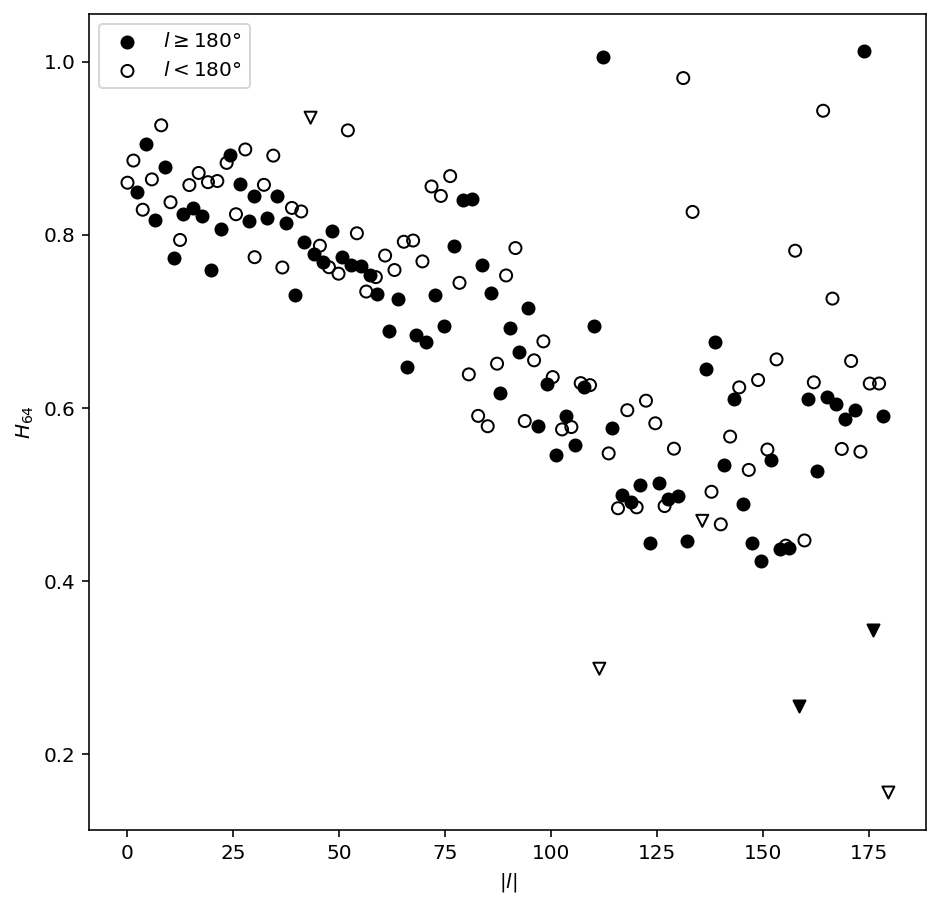

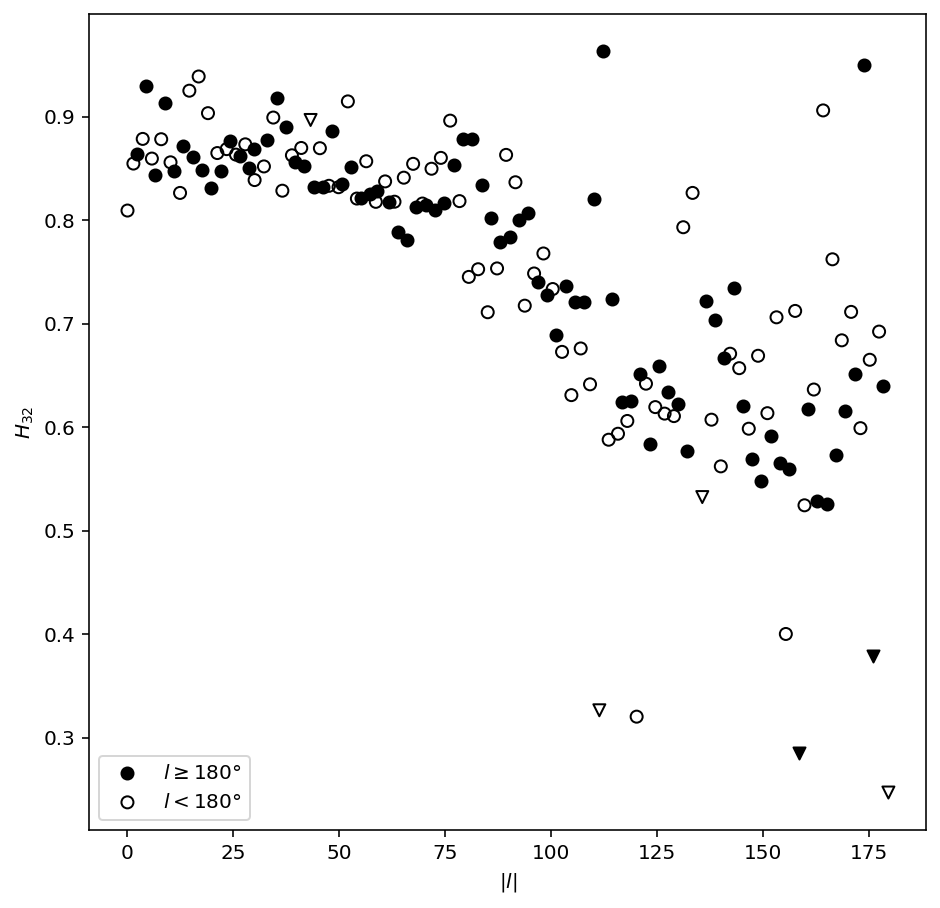

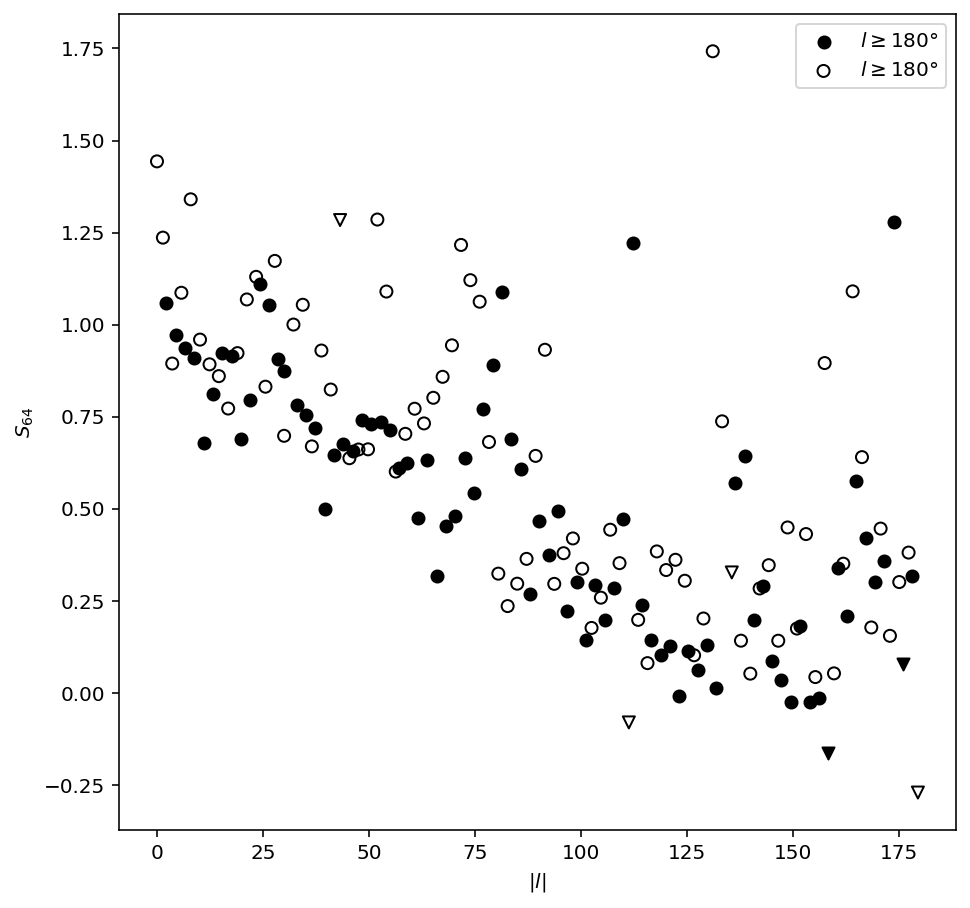

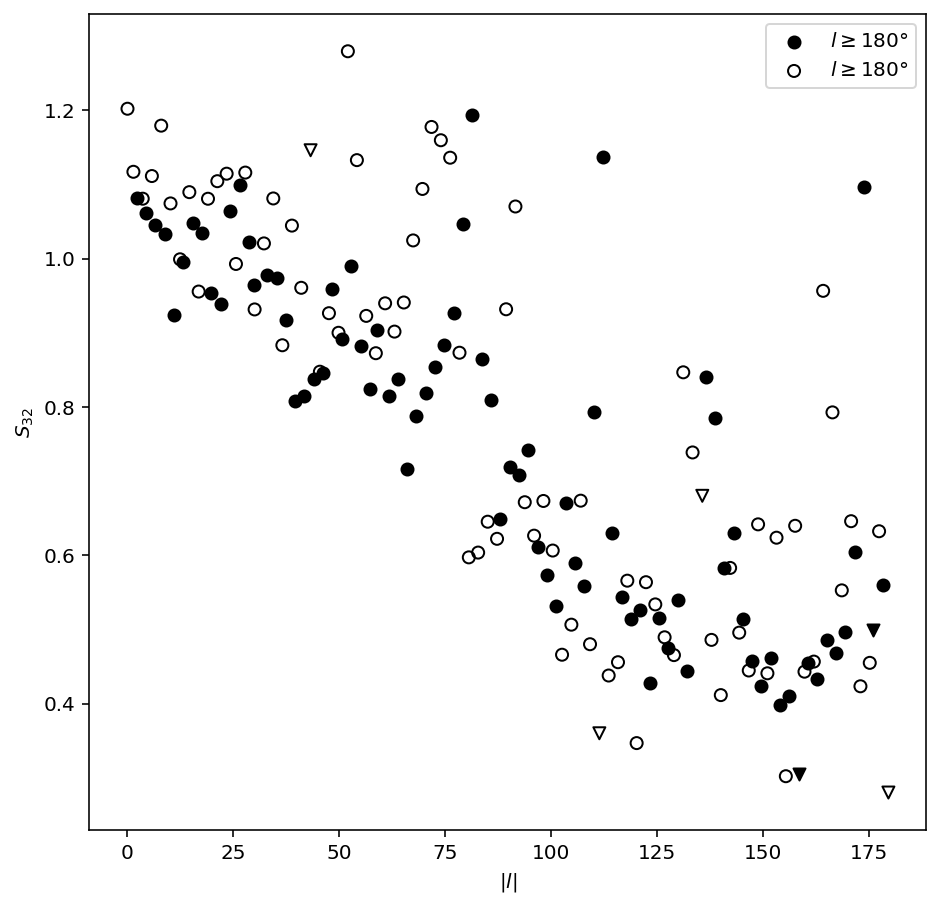

In [14]:
PATH = 'D:\Workshop\PhD\Papers\HiGal paper\Images'

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['H_mean_64'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
plt.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['H_mean_64'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
plt.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['H_mean_64'], 
            facecolors='k', edgecolors='k',
            marker='v')
plt.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['H_mean_64'], 
            facecolors='none', edgecolors='k',
            marker='v')
plt.xlabel(r'$|l|$')
plt.ylabel(r'$H_{64}$')
plt.legend()
plt.savefig(f'{PATH}/H64.png', bbox_inches="tight")
plt.show()



plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['H_mean_32'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
plt.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['H_mean_32'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
plt.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['H_mean_32'], 
            facecolors='k', edgecolors='k',
            marker='v')
plt.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['H_mean_32'], 
            facecolors='none', edgecolors='k',
            marker='v')
plt.xlabel(r'$|l|$')
plt.ylabel(r'$H_{32}$')
plt.legend()
plt.savefig(f'{PATH}/H32.png', bbox_inches="tight")
plt.show()


plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['S_mean_64'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
plt.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['S_mean_64'], 
            label = r'$l\geq180\degree$', 
            facecolors='none', edgecolors='k')
plt.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['S_mean_64'], 
            facecolors='k', edgecolors='k',
            marker='v')
plt.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['S_mean_64'], 
            facecolors='none', edgecolors='k',
            marker='v')
plt.xlabel(r'$|l|$')
plt.ylabel(r'$S_{64}$')
plt.legend()
plt.savefig(f'{PATH}/S64.png', bbox_inches="tight")
plt.show()

plt.figure(figsize=(1080/144, 1080/144), dpi=144)
plt.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['S_mean_32'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
plt.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['S_mean_32'], 
            label = r'$l\geq180\degree$', 
            facecolors='none', edgecolors='k')
plt.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['S_mean_32'], 
            facecolors='k', edgecolors='k',
            marker='v')
plt.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['S_mean_32'], 
            facecolors='none', edgecolors='k',
            marker='v')
plt.xlabel(r'$|l|$')
plt.ylabel(r'$S_{32}$')
plt.legend()
plt.savefig(f'{PATH}/S32.png', bbox_inches="tight")
plt.show()

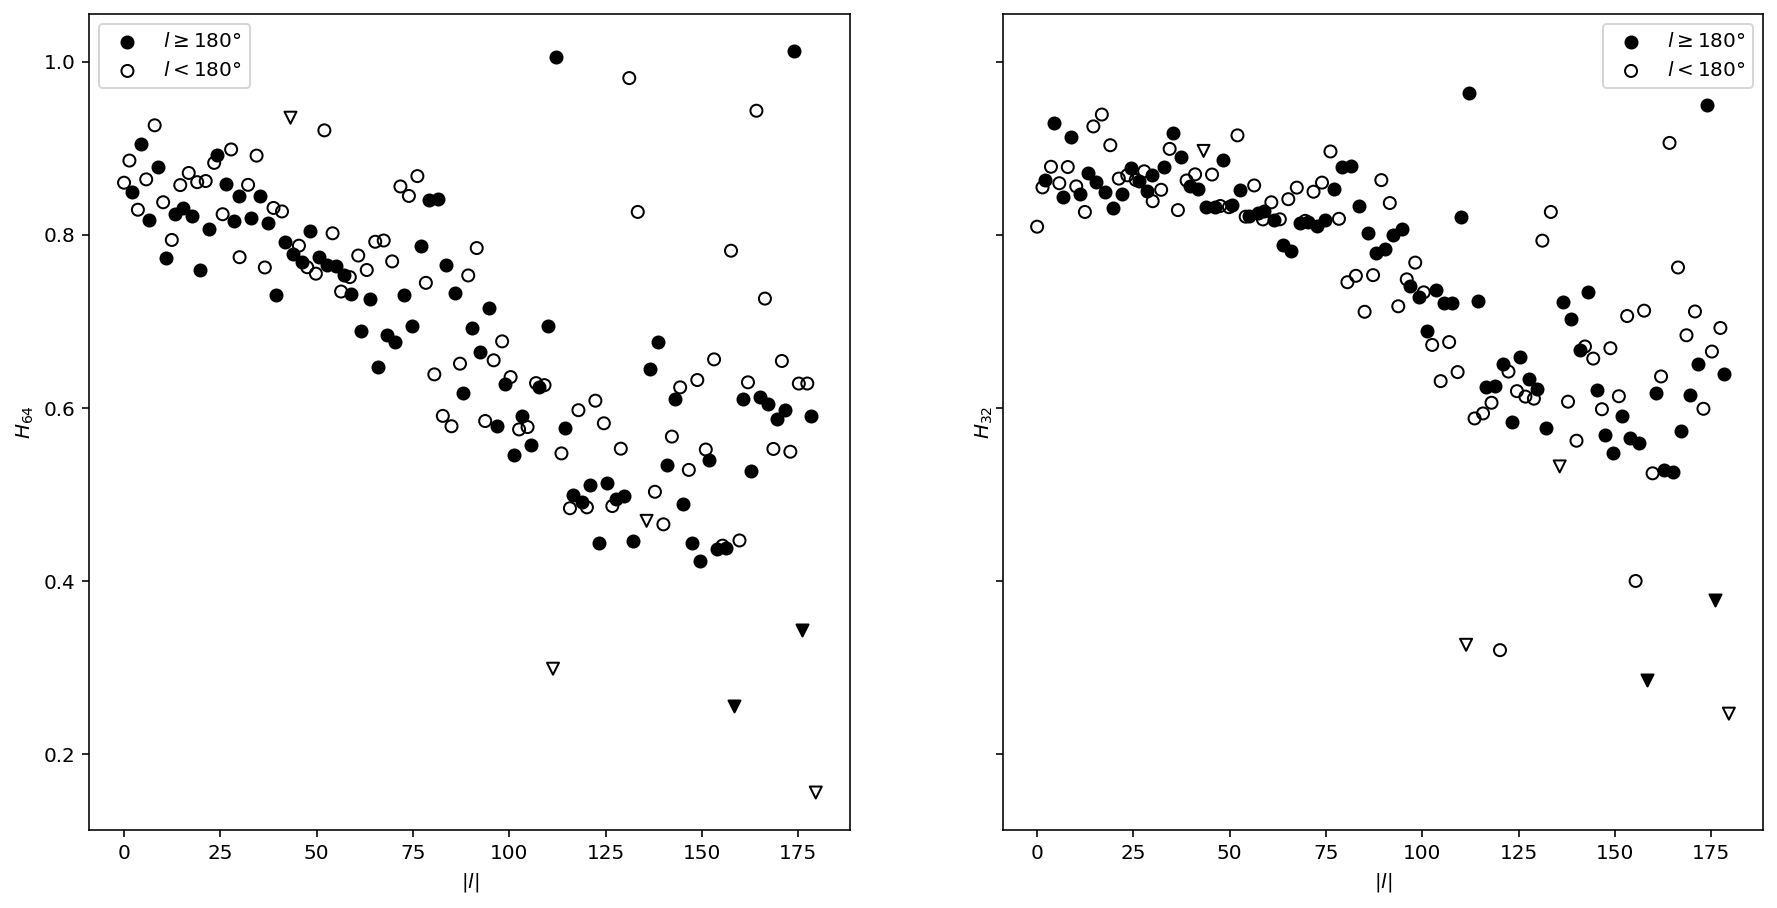

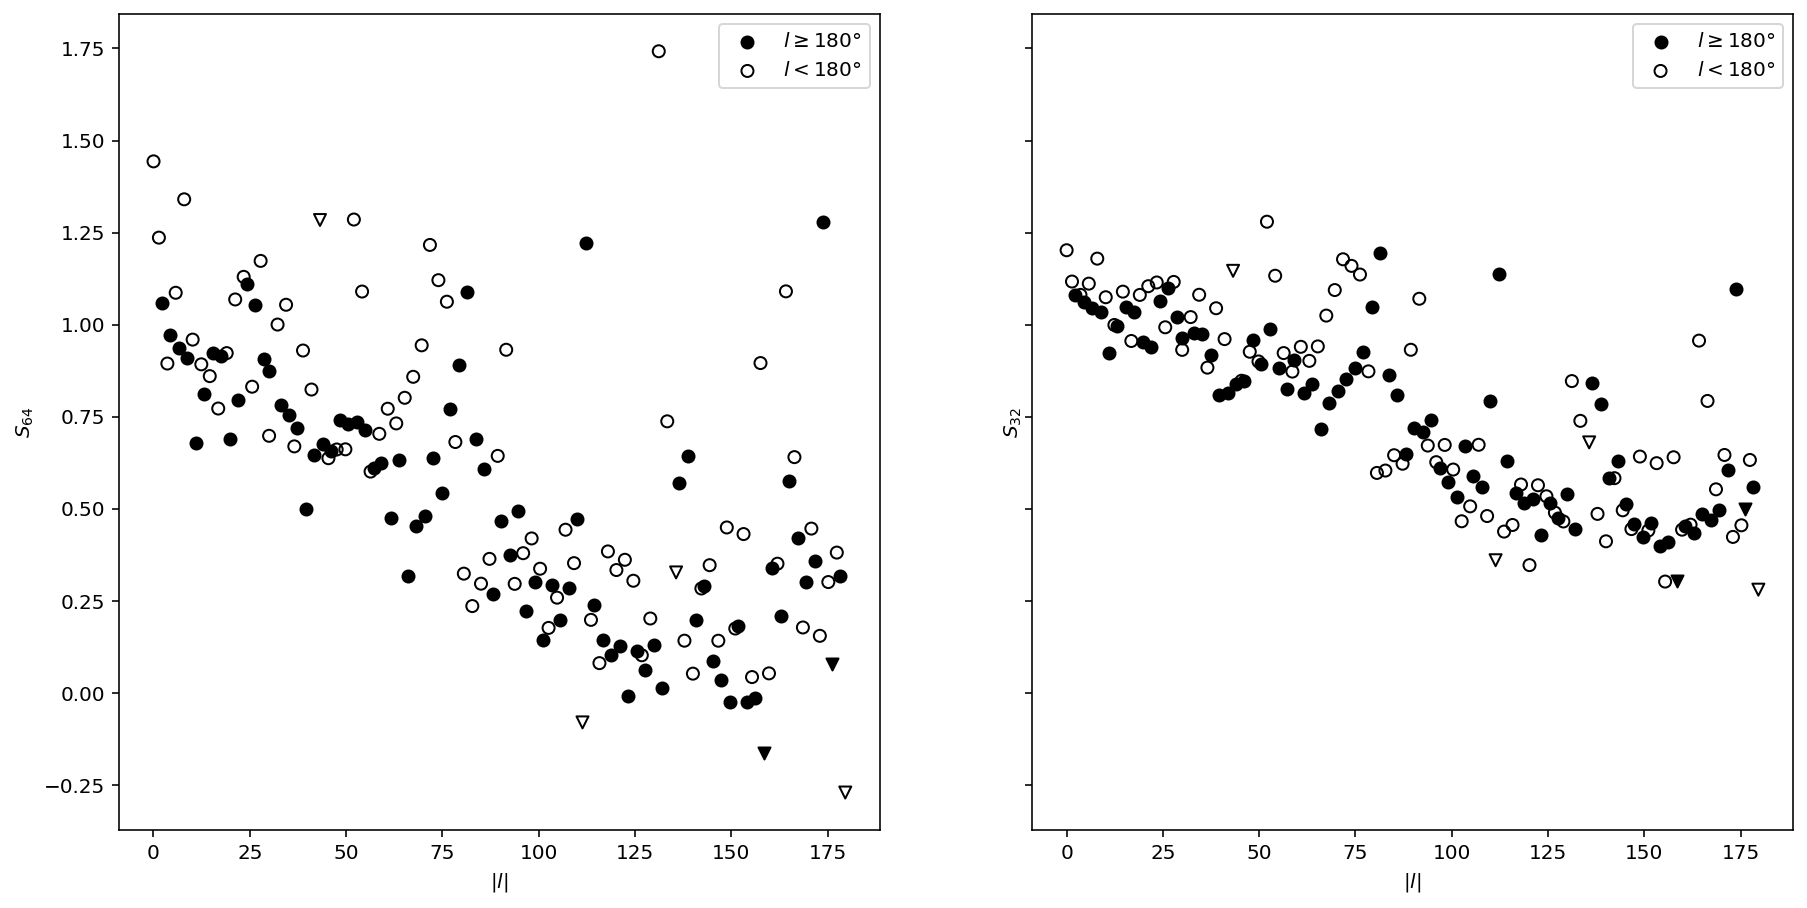

In [15]:
plt.rcParams.update({'font.size': 10})
f, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(2160/144, 1080/144), dpi=144)
ax1.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['H_mean_64'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
ax1.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['H_mean_64'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
ax1.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['H_mean_64'], 
            facecolors='k', edgecolors='k',
            marker='v')
ax1.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['H_mean_64'], 
            facecolors='none', edgecolors='k',
            marker='v')
ax1.set_xlabel(r'$|l|$')
ax1.set_ylabel(r'$H_{64}$')
ax1.legend()

ax2.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['H_mean_32'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
ax2.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['H_mean_32'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
ax2.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['H_mean_32'], 
            facecolors='k', edgecolors='k',
            marker='v')
ax2.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['H_mean_32'], 
            facecolors='none', edgecolors='k',
            marker='v')
ax2.set_xlabel(r'$|l|$')
ax2.set_ylabel(r'$H_{32}$')
ax2.legend()
plt.savefig(f'{PATH}/H.png', bbox_inches="tight")
plt.show()


f, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(2160/144, 1080/144), dpi=144)
ax1.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['S_mean_64'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
ax1.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['S_mean_64'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
ax1.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['S_mean_64'], 
            facecolors='k', edgecolors='k',
            marker='v')
ax1.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['S_mean_64'], 
            facecolors='none', edgecolors='k',
            marker='v')
ax1.set_xlabel(r'$|l|$')
ax1.set_ylabel(r'$S_{64}$')
ax1.legend()

ax2.scatter(progress_df[progress_df['l_shift']>=0]['l_shift'],
            progress_df[progress_df['l_shift']>=0]['S_mean_32'], 
            label = r'$l\geq180\degree$', 
            facecolors='k', edgecolors='k')
ax2.scatter(np.abs(progress_df[progress_df['l_shift']<0]['l_shift']),
            progress_df[progress_df['l_shift']<0]['S_mean_32'], 
            label = r'$l<180\degree$',
            facecolors='none', edgecolors='k')
ax2.scatter(star_plots[star_plots['l_shift']>=0]['l_shift'],
            star_plots[star_plots['l_shift']>=0]['S_mean_32'], 
            facecolors='k', edgecolors='k',
            marker='v')
ax2.scatter(np.abs(star_plots[star_plots['l_shift']<0]['l_shift']),
            star_plots[star_plots['l_shift']<0]['S_mean_32'], 
            facecolors='none', edgecolors='k',
            marker='v')
ax2.set_xlabel(r'$|l|$')
ax2.set_ylabel(r'$S_{32}$')
ax2.legend()
plt.savefig(f'{PATH}/S.png', bbox_inches="tight")
plt.show()